In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tskit
import tsinfer

print(f"tskit {tskit.__version__}")
print(f"tsinfer {tsinfer.__version__}")

tskit 0.5.3
tsinfer 0.3.0


### Load data

In [2]:
ts_file = "/home/shing_zhan/analysis/map_truncated/chr20_p.imputed.trees"


In [3]:
ts = tskit.load(ts_file)
ts

### Correlation between edge span and edge time

In [4]:
edge_spans = ts.edges_right - ts.edges_left
edge_parent_times = ts.nodes_time[ts.edges_parent]
edge_child_times = ts.nodes_time[ts.edges_child]

if edge_spans[-1] == ts.sequence_length:
    edge_spans = edge_spans[:-2]
    edge_parent_times = edge_parent_times[:-2]
    edge_child_times = edge_child_times[:-2]

edge_spans = edge_spans / 1e6

df_edges = pd.DataFrame({
    'edge_spans': edge_spans,
    'edge_parent_times': edge_parent_times,
    'edge_child_times': edge_child_times,
})

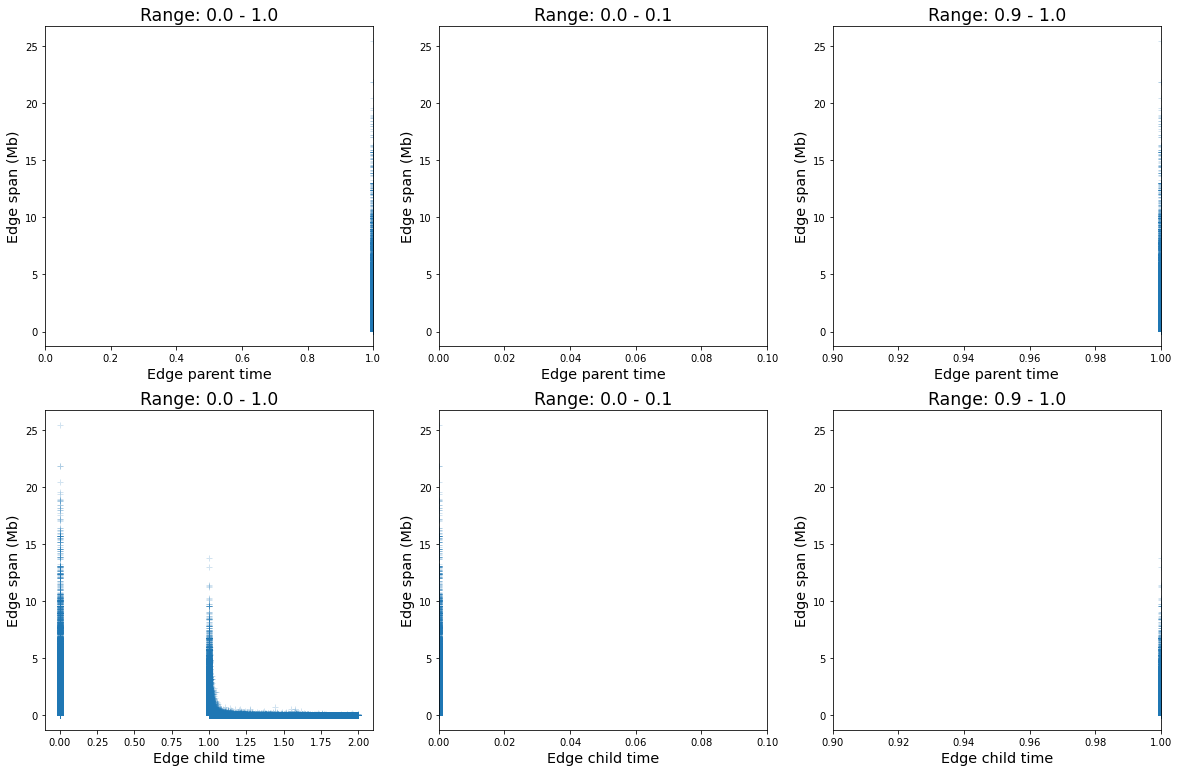

In [5]:
plt.figure(figsize=(20, 20,))

plt.subplot(331)
plt.title("Range: 0.0 - 1.0", fontsize="xx-large")
plt.xlabel("Edge parent time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.xlim(0.0, 1.0)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(332)
plt.title("Range: 0.0 - 0.1", fontsize="xx-large")
plt.xlabel("Edge parent time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(333)
plt.title("Range: 0.9 - 1.0", fontsize="xx-large")
plt.xlabel("Edge parent time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(334)
plt.title("Range: 0.0 - 1.0", fontsize="xx-large")
plt.xlabel("Edge child time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(335)
plt.title("Range: 0.0 - 0.1", fontsize="xx-large")
plt.xlabel("Edge child time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(336)
plt.title("Range: 0.9 - 1.0", fontsize="xx-large")
plt.xlabel("Edge child time", fontsize="x-large")
plt.ylabel("Edge span (Mb)", fontsize="x-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.show()

### Correlation between node span and node time

In [6]:
node_spans = tsinfer.node_span(ts)
node_times = ts.nodes_time

if node_spans[-1] == ts.sequence_length:
    node_spans = node_spans[:-2]
    node_times = node_times[:-2]

node_spans = node_spans / 1e6

df_nodes = pd.DataFrame({
    'node_spans': node_spans,
    'node_times': node_times,
})

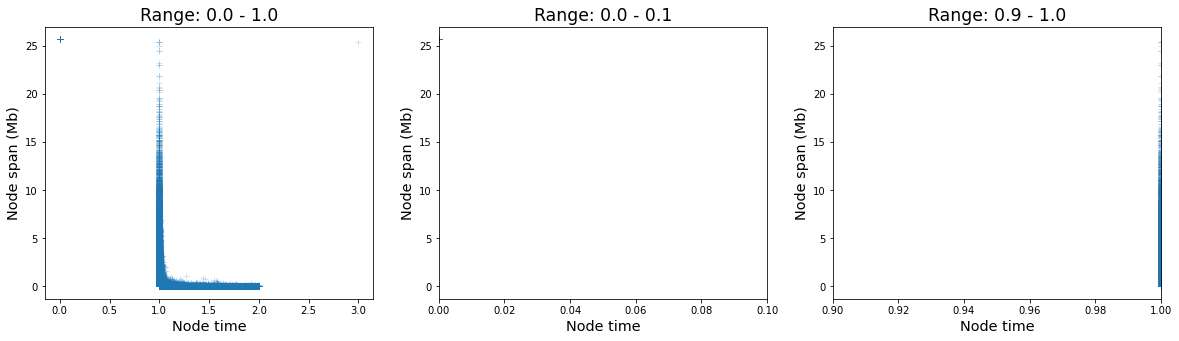

In [7]:
plt.figure(figsize=(20, 5,))

plt.subplot(131)
plt.title("Range: 0.0 - 1.0", fontsize="xx-large")
plt.xlabel("Node time", fontsize="x-large")
plt.ylabel("Node span (Mb)", fontsize="x-large")
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(132)
plt.title("Range: 0.0 - 0.1", fontsize="xx-large")
plt.xlabel("Node time", fontsize="x-large")
plt.ylabel("Node span (Mb)", fontsize="x-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(133)
plt.title("Range: 0.9 - 1.0", fontsize="xx-large")
plt.xlabel("Node time", fontsize="x-large")
plt.ylabel("Node span (Mb)", fontsize="x-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

### Distribution of mutations per site

In [8]:
site_pos, counts = np.unique(ts.mutations_site, return_counts=True)
num_sites_with_mutation = len(site_pos)
print(f"Sites total: {'{:,}'.format(ts.num_sites)}")
print(f"Sites with >= 1 mutation: {'{:,}'.format(num_sites_with_mutation)}")
print(f"Sites with >= 1 mutation: {round(num_sites_with_mutation / ts.num_sites, 2)}")

Sites total: 136,087
Sites with >= 1 mutation: 114,352
Sites with >= 1 mutation: 0.84


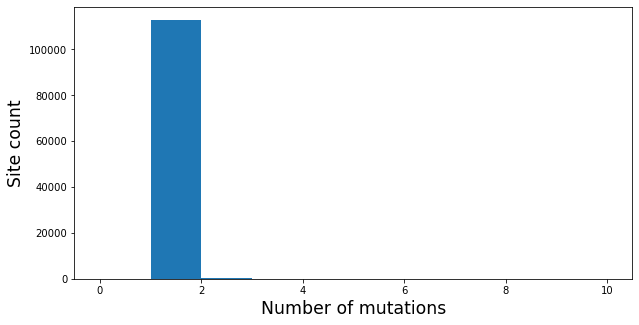

In [9]:
plt.figure(figsize=(10, 5,))
plt.ylabel("Site count", fontsize="xx-large")
plt.xlabel("Number of mutations", fontsize="xx-large")
plt.hist(counts, bins=range(11));
plt.show()

### Distribution of arity

In [10]:
# Unsimplified, a tree sequence contains unary nodes,
# so exclude them before calculating arity.
ts_simplified = ts.simplify()

# For each tree, take the mean arity across its nodes.
tree_arity = np.empty(ts_simplified.num_trees - 2)
for i, tree in enumerate(ts_simplified.trees()):
    # Exclude the first and last trees, as the parent id of all the nodes are -1.
    if i in [0, ts_simplified.num_trees - 1]:
        continue
    parent_id, count = np.unique(tree.parent_array[tree.preorder()], return_counts=True)
    tree_arity[i - 1] = count[parent_id != tskit.NULL].mean()

# For each node, take the mean arity across trees.
# Exclude the sample nodes, as they have arity of 0.
node_arity = np.zeros(ts_simplified.num_nodes - ts_simplified.num_samples)
node_span = np.zeros(ts_simplified.num_nodes - ts_simplified.num_samples)
for tree in ts_simplified.trees():
    node_arity += tree.num_children_array[ts_simplified.num_samples:-1] * tree.span
    node_span[tree.num_children_array[ts_simplified.num_samples:-1] > 0] += tree.span
node_arity /= node_span

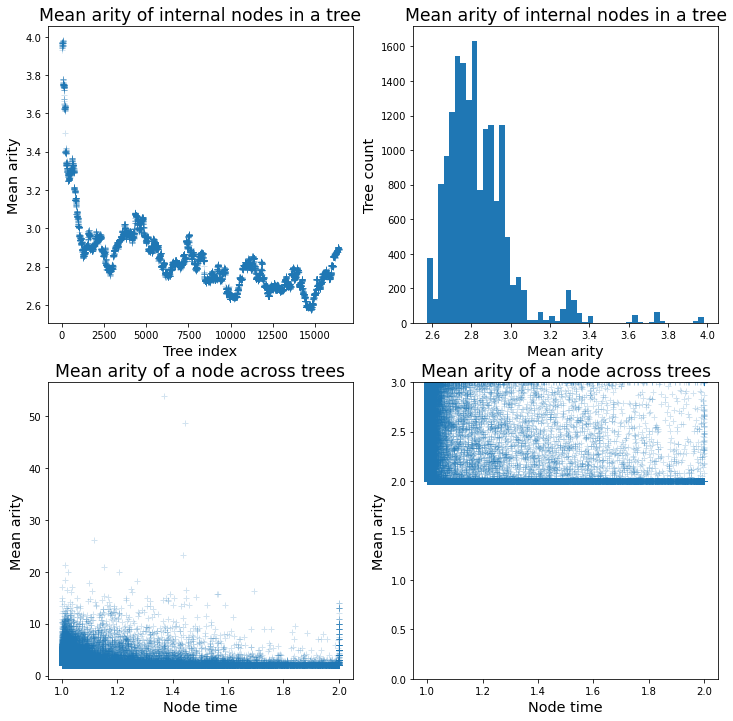

In [11]:
plt.figure(figsize=(12, 12,))

plt.subplot(221)
plt.title("Mean arity of internal nodes in a tree", fontsize="xx-large")
plt.ylabel("Mean arity", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(tree_arity.shape[0]),
    tree_arity,
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(222)
plt.title("Mean arity of internal nodes in a tree", fontsize="xx-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Mean arity", fontsize="x-large")
plt.hist(tree_arity, bins=50);

plt.subplot(223)
plt.title("Mean arity of a node across trees", fontsize="xx-large")
plt.ylabel("Mean arity", fontsize="x-large")
plt.xlabel("Node time", fontsize="x-large")
plt.plot(
    ts_simplified.nodes_time[ts_simplified.num_samples:],
    node_arity,
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(224)
plt.title("Mean arity of a node across trees", fontsize="xx-large")
plt.ylabel("Mean arity", fontsize="x-large")
plt.xlabel("Node time", fontsize="x-large")
plt.ylim(0, 3)
plt.plot(
    ts_simplified.nodes_time[ts_simplified.num_samples:],
    node_arity,
    linestyle='none', marker='+', markersize=6, alpha=0.2,
)

plt.show()

### Distribution of edge diffs

In [12]:
tree_edges_out = np.empty(ts.num_trees)
tree_edges_in = np.empty(ts.num_trees)
for i, (interval, edges_out, edges_in,) in enumerate(ts.edge_diffs()):
    tree_edges_out[i] = len(edges_out)
    tree_edges_in[i] = len(edges_in)

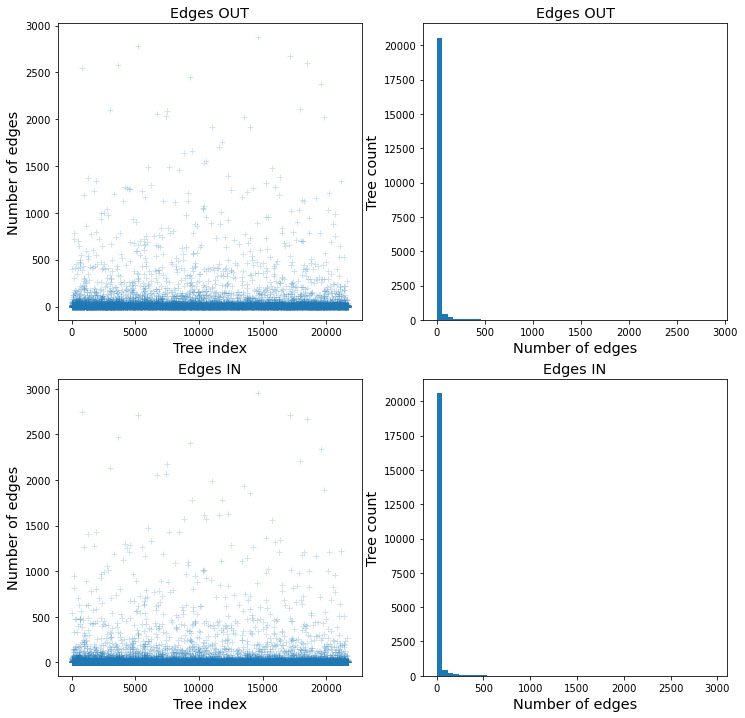

In [13]:
# Exclude the first, second, penultimate, and last sets of edge diffs.
plt.figure(figsize=(12, 12,))

plt.subplot(221)
plt.title("Edges OUT", fontsize="x-large")
plt.ylabel("Number of edges", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(2, ts.num_trees - 2),
    tree_edges_out[2:-2],
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(222)
plt.title("Edges OUT", fontsize="x-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(tree_edges_out[2:-2], bins=50);

plt.subplot(223)
plt.title("Edges IN", fontsize="x-large")
plt.ylabel("Number of edges", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(2, ts.num_trees - 2),
    tree_edges_in[2:-2],
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(224)
plt.title("Edges IN", fontsize="x-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(tree_edges_in[2:-2], bins=50);

plt.show()

### Sample edges

In [14]:
per_sample_num_edges = np.empty(ts.num_samples)
per_sample_bkpt_density = np.empty(ts.num_samples)
per_sample_mean_parent_time = np.empty(ts.num_samples)

# TODO: Is there a faster way than appending to a Python list?
left_coords_all = []
parent_times_all = []

all_edges = ts.tables.edges
for i in ts.samples():
    assert ts.nodes_time[i] == 0
    # Subset edges table
    tmp_tb = all_edges[ts.tables.edges.child == i]
    # Get number of edges copying into a sample
    tmp_num_edges = tmp_tb.child.shape[0]
    per_sample_num_edges[i] = tmp_num_edges
    # Get the left coordinates of these edges
    tmp_left_coords = tmp_tb.left
    left_coords_all += list(tmp_left_coords)
    # Get the parent times of these edges
    tmp_parent_times = ts.nodes_time[tmp_tb.parent]
    parent_times_all += list(tmp_parent_times)
    assert tmp_left_coords.shape[0] == tmp_parent_times.shape[0]
    # Get the per-sample breakpoint density (per 1 Mb)
    per_sample_bkpt_density[i] = tmp_left_coords.shape[0] / (ts.sequence_length / 1e6)
    # Get the per-sample mean parent time
    per_sample_mean_parent_time[i] = np.mean(tmp_parent_times)

left_coords_all = np.array(left_coords_all)
parent_times_all = np.array(parent_times_all)

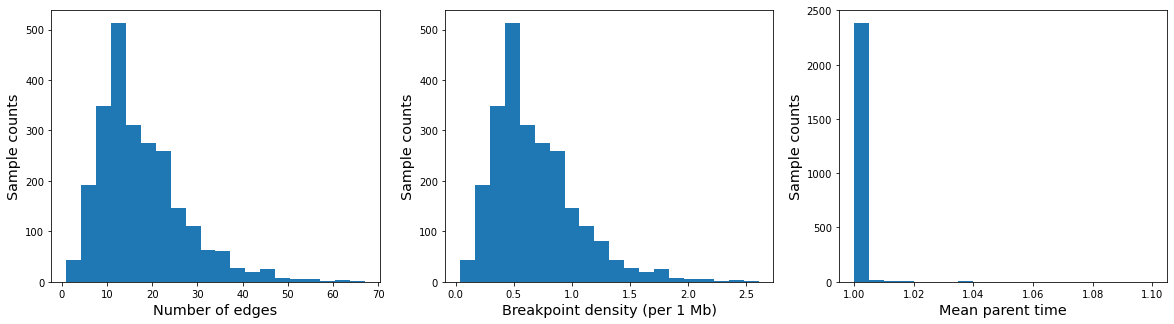

In [15]:
plt.figure(figsize=(20, 5,))

plt.subplot(131)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(per_sample_num_edges, bins=20);

plt.subplot(132)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Breakpoint density (per 1 Mb)", fontsize="x-large")
plt.hist(per_sample_bkpt_density, bins=20);

plt.subplot(133)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Mean parent time", fontsize="x-large")
plt.hist(per_sample_mean_parent_time, bins=20);

plt.show()

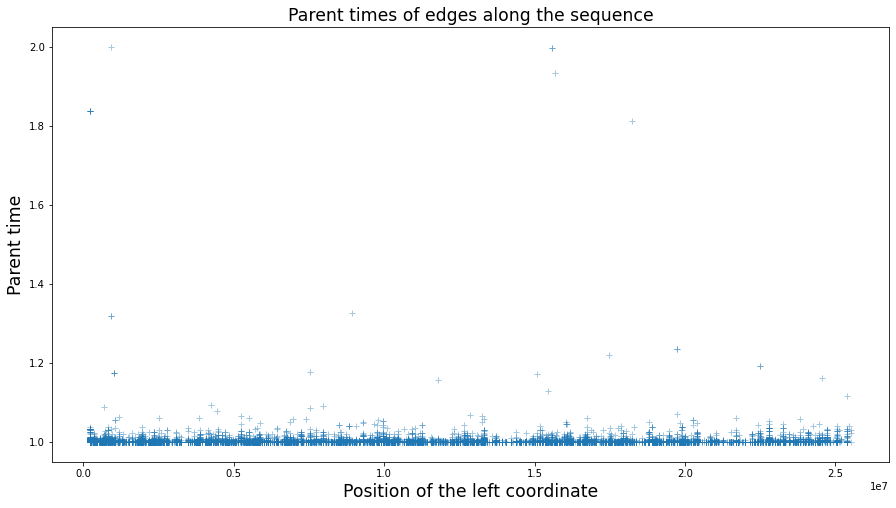

In [16]:
plt.figure(figsize=(15, 8,))
plt.title("Parent times of edges along the sequence", fontsize="xx-large")
plt.ylabel("Parent time", fontsize="xx-large")
plt.xlabel("Position of the left coordinate", fontsize="xx-large")
plt.plot(
    left_coords_all,
    parent_times_all,
    linestyle="none", marker="+", markersize=6, alpha=0.4,
);
plt.show()

In [17]:
num_bins = int(np.ceil(ts.sequence_length / 1e6))
bkpt_binned_counts = np.zeros(num_bins)
for i in np.arange(num_bins):
    is_right = i * 1e6 <= left_coords_all
    is_left = left_coords_all < (i + 1) * 1e6
    bkpt_binned_counts[i] = np.sum(is_right & is_left) / 1e6    # No need to normalize

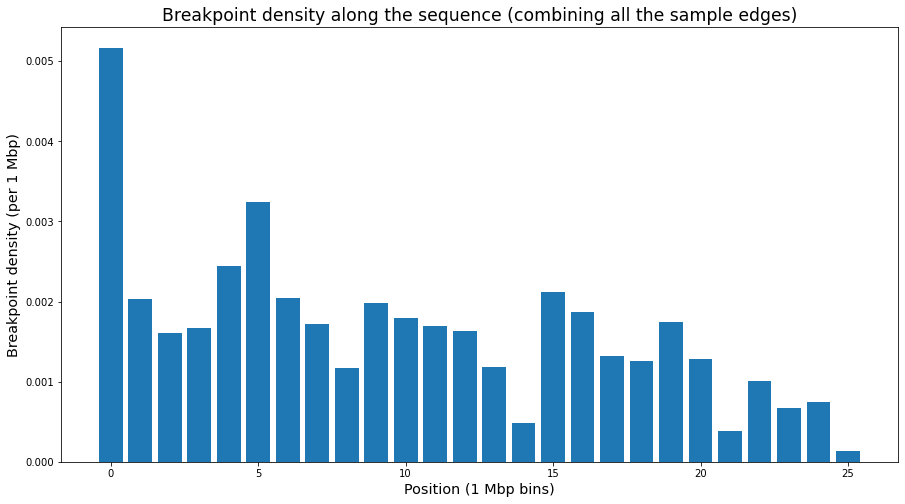

In [18]:
plt.figure(figsize=(15, 8,))
plt.title("Breakpoint density along the sequence (combining all the sample edges)", fontsize="xx-large")
plt.ylabel("Breakpoint density (per 1 Mbp)", fontsize="x-large")
plt.xlabel("Position (1 Mbp bins)", fontsize="x-large")
plt.bar(
    np.arange(num_bins),
    bkpt_binned_counts,
);
plt.show()

### Sites per tree

In [19]:
per_tree_num_sites = np.empty(ts.num_trees)
tree_span = np.empty(ts.num_trees)
for i, t in enumerate(ts.trees()):
    per_tree_num_sites[i] = t.num_sites
    tree_span[i] = t.span

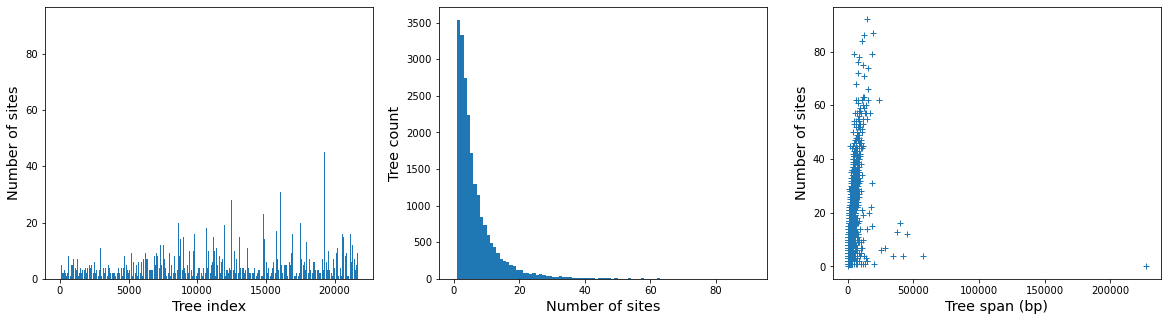

In [20]:
plt.figure(figsize=(20, 5,))

plt.subplot(131)
plt.ylabel("Number of sites", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.bar(
    np.arange(ts.num_trees),
    per_tree_num_sites
);

plt.subplot(132)
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Number of sites", fontsize="x-large")
plt.hist(per_tree_num_sites, bins=range(int(np.max(per_tree_num_sites))));

plt.subplot(133)
plt.ylabel("Number of sites", fontsize="x-large")
plt.xlabel("Tree span (bp)", fontsize="x-large")
plt.plot(
    tree_span,
    per_tree_num_sites,
    linestyle="none",
    marker="+",
    markersize=6,
);

plt.show()

### Minor allele frequencies

In [21]:
# Min threshold to define common minor alleles
min_maf_threshold = 0.05

sites_maf_zero = 0
maf = np.zeros(ts.num_sites)
for i, v in enumerate(ts.variants()):
    maf[i] = min(v.frequencies(remove_missing=True).values())
    if maf[i] == 0:
        sites_maf_zero += 1
print(f"Sites with MAF = 0: {sites_maf_zero}")

num_bins = int(np.ceil(ts.sequence_length / 1e6))
maf_binned_counts = np.zeros(num_bins)
for i in np.arange(num_bins):
    is_right = i * 1e6 < ts.sites_position
    is_left = ts.sites_position <= (i + 1) * 1e6
    is_lt_min = maf < min_maf_threshold
    maf_binned_counts[i] = np.sum(is_right & is_left & is_lt_min)

Sites with MAF = 0: 277


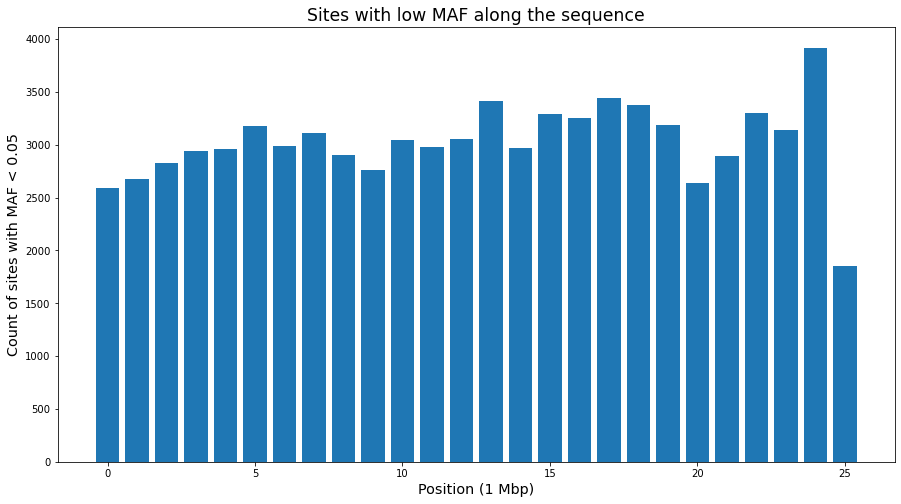

In [22]:
plt.figure(figsize=(15, 8,))
plt.title("Sites with low MAF along the sequence", fontsize="xx-large")
plt.ylabel(f"Count of sites with MAF < {min_maf_threshold}", fontsize="x-large")
plt.xlabel("Position (1 Mbp)", fontsize="x-large")
plt.bar(
    np.arange(num_bins),
    maf_binned_counts,
);

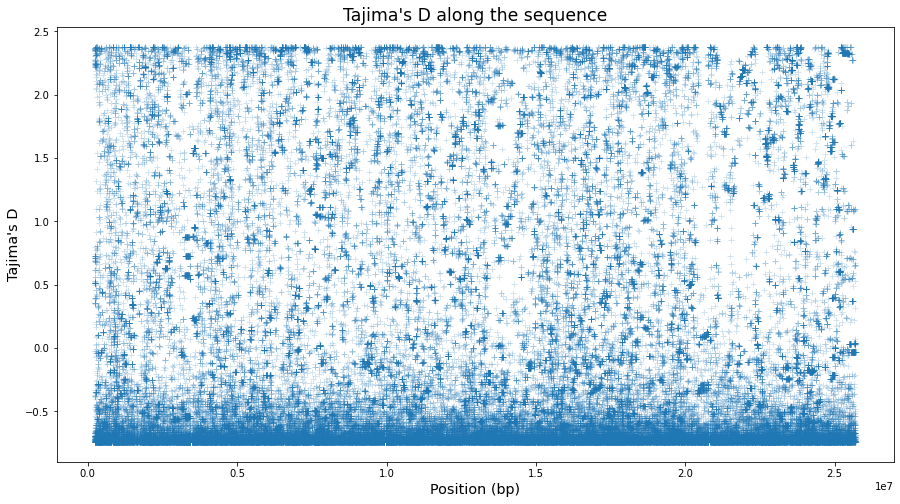

In [23]:
# Not more useful than above.
D = ts.Tajimas_D(mode="site", windows="sites")
plt.figure(figsize=(15, 8,))
plt.title("Tajima's D along the sequence", fontsize="xx-large")
plt.ylabel("Tajima's D", fontsize="x-large")
plt.xlabel("Position (bp)", fontsize="x-large")
plt.plot(
    ts.sites_position,
    D,
    linestyle="none",
    marker="+",
    markersize=6,
    alpha=0.2,
);
plt.show()

### Samples with old edges

In [24]:
# Get samples with edges whose parents are at least `min_time_threshold`` old.
min_time_threshold = 1.9

samples_old_parents = []    # Samples with edges copying from old parents.
samples_num_edges = []  # Number of edges that the samples above possess.
samples_num_mutations = []  # Number of mutations that the samples above possess.

all_edges = ts.tables.edges
for sample_id in ts.samples():
    sample_edges = all_edges[all_edges.child == sample_id]
    # Get time of the parent nodes
    parent_times = ts.nodes_time[sample_edges.parent]

    if np.any(parent_times >= min_time_threshold):
        num_edges = len(sample_edges.child)
        num_mutations = np.sum(ts.mutations_node == sample_id)

        samples_old_parents.append(sample_id)
        samples_num_edges.append(num_edges)
        samples_num_mutations.append(num_mutations)

In [25]:
print(f"Old parents have a time greater than or equal to: {min_time_threshold}")
print(f"Samples with edges copying from old parents: {len(samples_old_parents)}")

Old parents have a time greater than or equal to: 1.9
Samples with edges copying from old parents: 4


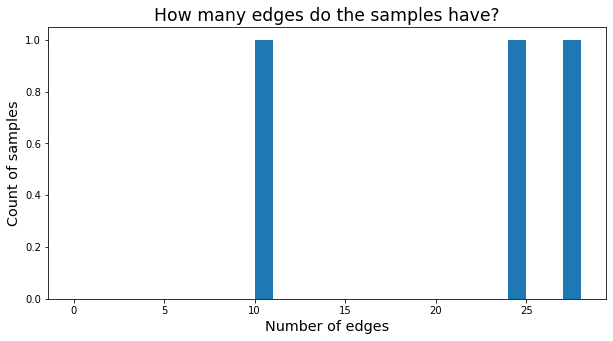

In [26]:
plt.figure(figsize=(10, 5))
plt.title("How many edges do the samples have?", fontsize="xx-large")
plt.ylabel("Count of samples", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(samples_num_edges, bins=np.arange(max(max(samples_num_edges), 5)));

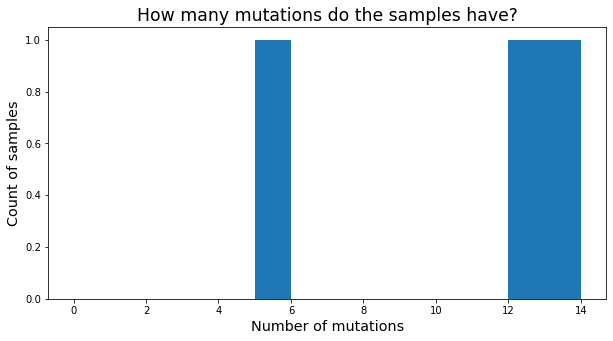

In [27]:
plt.figure(figsize=(10, 5))
plt.title("How many mutations do the samples have?", fontsize="xx-large")
plt.ylabel("Count of samples", fontsize="x-large")
plt.xlabel("Number of mutations", fontsize="x-large")
plt.hist(samples_num_mutations, bins=np.arange(max(max(samples_num_mutations), 5)));